In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder

from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold,RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score,classification_report,precision_score,recall_score
from sklearn.metrics import classification_report, roc_curve, confusion_matrix
from sklearn.metrics import precision_recall_curve, roc_auc_score

from collections import Counter
from sklearn.model_selection import KFold,StratifiedKFold
# modelos
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.ensemble import  ExtraTreesClassifier,VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline



In [2]:
data = pd.read_csv('healthcare-dataset-stroke-data.csv')

In [3]:
data.head(5)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
# drop 'id' column
# without id 
data = data.drop(['id'], axis=1)

To fill in the gaps in bmi, we use the following method. 
1. Create a new column "age_mean". Divide the age of all users into 5 ranges.
2. Calculate the average bmi value for each age range.
3. Fill in the blanks by replacing the empty values with the average bmi based on age_mean.

In [5]:

label = [1,2,3,4,5]
data["age_mean"] = pd.cut(data["age"], 5, labels = label)
data["age_mean"].value_counts()
bmi_group = data.groupby("age_mean")["bmi"].mean() #将年龄阶段分为五组，分别计算平均的bmi
bmi_group

age_mean
1    20.787661
2    28.601332
3    31.425088
4    31.580618
5    29.415118
Name: bmi, dtype: float64

In [7]:
def bmi_val(cols): # Assign average bmi by age range 
    bmi = cols[0]
    age_mean = cols[1]
    
    if pd.isnull(bmi):
        if age_mean == 1:
            return 20.7
        elif age_mean == 2:
            return 28.6
        elif age_mean == 3:
            return 31.4
        elif age_mean == 4:
            return 31.6
        elif age_mean == 5:
            return 29.4
    else:
        return bmi

In [8]:
data["bmi"] = data[["bmi","age_mean"]].apply(bmi_val, axis=1)

In [9]:
data.isnull().sum() 

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
age_mean             0
dtype: int64

In [10]:
#Change 'other' to ‘Female’
data.gender = data.gender.apply(
    lambda x: 0 
    if ((x == 'Female') or (x == 'Other')) 
    else 1)



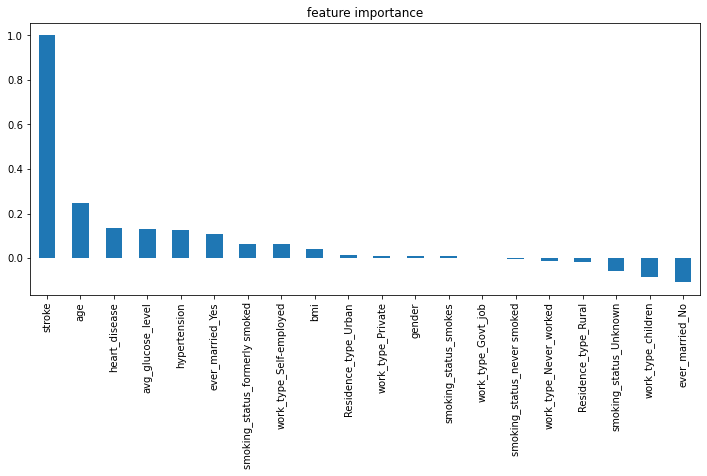

In [11]:
data1 = data.drop('age_mean', axis = 1)
#print(data1.head(2))
one_hot_data = pd.get_dummies(data1.iloc[:,:])
#one_hot_data.head(2)
plt.figure(figsize=(12,5))
one_hot_data.corr()["stroke"].sort_values(ascending=False).plot(kind="bar")
plt.title('feature importance')
plt.show()

In [12]:
# Encode the target tag with values between 0 and n_classes-1 / encode the classification characteristics as a one-key numeric array
one_hot = OneHotEncoder()

data['gender'] = pd.Categorical(data['gender'])
d_gender = pd.get_dummies(data['gender'],prefix='gender_encoded')

data['smoking_status']=pd.Categorical(data['smoking_status'])
d_smoking_status=pd.get_dummies(data['smoking_status'],prefix='smoking_status_encode')

data['work_type'] = pd.Categorical(data['work_type'])
d_work_type = pd.get_dummies(data['work_type'], prefix = 'work_type_encoded')

data['Residence_type'] = pd.Categorical(data['Residence_type'])
d_Residence_type = pd.get_dummies(data['Residence_type'], prefix = 'Residence_type_encoded')

data['ever_married'] = pd.Categorical(data['ever_married'])
d_ever_married = pd.get_dummies(data['ever_married'], prefix = 'ever_married_encoded')

#delete cols
data.drop(['gender'], axis=1, inplace=True)
data.drop(["work_type"], axis=1, inplace=True)
data.drop(["smoking_status"], axis=1, inplace=True)
data.drop(["Residence_type"], axis=1, inplace=True)
data.drop(["ever_married"], axis=1, inplace=True)
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   age                5110 non-null   float64 
 1   hypertension       5110 non-null   int64   
 2   heart_disease      5110 non-null   int64   
 3   avg_glucose_level  5110 non-null   float64 
 4   bmi                5110 non-null   float64 
 5   stroke             5110 non-null   int64   
 6   age_mean           5110 non-null   category
dtypes: category(1), float64(3), int64(3)
memory usage: 244.8 KB


In [13]:
# Add new columns 
data=pd.concat([data,d_gender],axis=1)
data=pd.concat([data,d_work_type],axis=1)
data=pd.concat([data,d_smoking_status],axis=1)
data=pd.concat([data,d_Residence_type],axis=1)
data=pd.concat([data,d_ever_married],axis=1)
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 22 columns):
 #   Column                                 Non-Null Count  Dtype   
---  ------                                 --------------  -----   
 0   age                                    5110 non-null   float64 
 1   hypertension                           5110 non-null   int64   
 2   heart_disease                          5110 non-null   int64   
 3   avg_glucose_level                      5110 non-null   float64 
 4   bmi                                    5110 non-null   float64 
 5   stroke                                 5110 non-null   int64   
 6   age_mean                               5110 non-null   category
 7   gender_encoded_0                       5110 non-null   uint8   
 8   gender_encoded_1                       5110 non-null   uint8   
 9   work_type_encoded_Govt_job             5110 non-null   uint8   
 10  work_type_encoded_Never_worked         5110 non-null   uint8

In [14]:
data = data.drop(['age_mean'],axis=1)
print(data.shape)

(5110, 21)


using SMOTE method to optimize the imbalanced dataset

In [15]:
k_values = [1, 2, 3, 4, 5, 6, 7]
X = data.drop(['stroke'], axis=1)
y = data.stroke

k_scores = []
for k in k_values:
    # define pipeline
    rf = RandomForestClassifier()
    over  = SMOTE(sampling_strategy = 0.1, k_neighbors = k)
    steps = [('over', over), ('model', rf)]
    
    pipeline = Pipeline(steps=steps)
    
    # evaluate pipeline
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    
    scores = cross_val_score(rf, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
    score = np.mean(scores)
    k_scores.append((k, score))
    print('> k=%d, Mean ROC AUC: %.3f' % (k, score))

> k=1, Mean ROC AUC: 0.790
> k=2, Mean ROC AUC: 0.795
> k=3, Mean ROC AUC: 0.792
> k=4, Mean ROC AUC: 0.797
> k=5, Mean ROC AUC: 0.787
> k=6, Mean ROC AUC: 0.792
> k=7, Mean ROC AUC: 0.792


In [16]:
sorted(k_scores, key=lambda tup: tup[1])
best_k = sorted(k_scores, key=lambda tup: tup[1])[-1][0]
print(best_k)

4


In [17]:
over  = SMOTE(k_neighbors=best_k)

steps = [('over', over)]
pipeline = Pipeline(steps=steps)
X, y = pipeline.fit_resample(X, y)
counter = Counter(y)
print('Number of stork(1) and non-stroke(0) data:', counter)

Number of stork(1) and non-stroke(0) data: Counter({1: 4861, 0: 4861})


In [18]:
# split the dataset into train dataset and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify = y, random_state=42)

In [19]:
# Initialization RandomForest algorithm (find the best parameters)
rf = RandomForestClassifier()

n_estimators = [100,500,700,1000]
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

grid =         {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

search_rf = RandomizedSearchCV(estimator = rf, param_distributions = grid, cv = 5, verbose=1, n_jobs=-1)


In [21]:
# training dataset, construct model
search_rf.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 500, 700, 1000]},
                   verbose=1)

In [22]:
# test models. 
preds_rf = search_rf.predict(X_test)

In [23]:
print("Random Forest:")
print(classification_report(y_test, preds_rf))  # 'Random Forest:',

Random Forest:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       973
           1       0.99      0.96      0.97       972

    accuracy                           0.98      1945
   macro avg       0.98      0.98      0.98      1945
weighted avg       0.98      0.98      0.98      1945



In [24]:
####  交叉验证
sf = StratifiedKFold(n_splits = 10, random_state=0, shuffle = True)
score_s=cross_val_score(search_rf, X, y, cv=sf)
print(score_s)
print("StratifiedKFold Mean Accuracy: {:.2f} %".format(score_s.mean() * 100))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0.97327852 0.97019527 0.98353909 0.96604938 0.97016461 0.96193416
 0.97736626 0.97427984 0.98045267 0.97222222]
StratifiedKFold Mean Accuracy: 97.29 %


In [26]:
#print(score_s)
print("StratifiedKFold Mean Accuracy: {:.2f} %".format(score_s.mean() * 100))

StratifiedKFold Mean Accuracy: 97.29 %


In [28]:
#  Random Forest
rf.fit(X_train, y_train)
features = X_train.columns # feature name
feature_importances_rf = rf.feature_importances_ # feature importace 
features_df_rf = pd.DataFrame({'Features':features,'Importance':feature_importances_rf})
features_df_rf.sort_values('Importance',inplace=True,ascending=False)
print(features_df_rf)

                                 Features  Importance
0                                     age    0.268048
3                       avg_glucose_level    0.099936
4                                     bmi    0.077468
12          smoking_status_encode_Unknown    0.059556
17           Residence_type_encoded_Urban    0.055911
18                ever_married_encoded_No    0.055016
14     smoking_status_encode_never smoked    0.049341
16           Residence_type_encoded_Rural    0.049200
13  smoking_status_encode_formerly smoked    0.039163
15           smoking_status_encode_smokes    0.036943
5                        gender_encoded_0    0.033776
7              work_type_encoded_Govt_job    0.032250
10        work_type_encoded_Self-employed    0.031560
6                        gender_encoded_1    0.031226
9               work_type_encoded_Private    0.029288
19               ever_married_encoded_Yes    0.023660
11             work_type_encoded_children    0.010181
1                           